In [85]:
#I made the workflow in a little notebook so the parameters are all here and its traceable.
#If you want to play around with it, it'll prob take some time since getting everything installed
#and woprking is a pain


In [3]:
import subprocess
import shlex
def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ''):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.hhm'
        args += ' -ohhm ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [4]:
#run hhblits
p, outfiles = runHHblits( './HOG25968.1.aln' , 'HOG25968' , 'hhblits', outdir = './' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , iterations = 1 , ncores = 8 , )
print(outfiles)

['./HOG25968.1.aln', 'HOG25968', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./HOG25968.1.aln -o ./HOG25968.hhr -n 1 -B 2000 -Z 2000 
['./HOG25968.hhr', None]


In [5]:
#parse results

import csb
import pandas as pd 

from csb.bio.io.hhpred import HHOutputParser
results = HHOutputParser(alignments=False).parse_file(outfiles[0])

newhits = {}
hitlist=[]
for hit in results:
    hitlist.append(hit.id)
    newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score    }}  )
      
hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])

print(hhdf.head())



         prob  len  score model chain
1A77_A  0.994  182  165.6  1A77     A
1B43_B  0.995  181  178.8  1B43     B
1BGX_T  0.985  146  136.1  1BGX     T
1CMW_A  0.987  144  140.9  1CMW     A
1HUX_B  0.980  230   95.5  1HUX     B


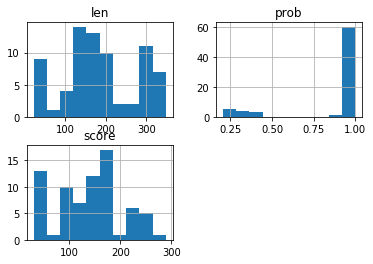

structure subset


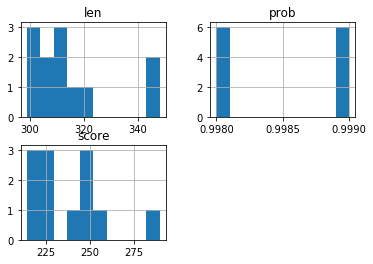

         prob  len  score model chain
2IVN_A  0.998  307  226.2  2IVN     A
2IVP_A  0.998  307  226.2  2IVP     A
2VWB_A  0.999  299  248.9  2VWB     A
3EN9_A  0.999  301  245.3  3EN9     A
3ENO_A  0.998  309  221.5  3ENO     A
3ENO_B  0.998  309  221.5  3ENO     B
3WUH_B  0.999  348  255.2  3WUH     B
3ZEU_B  0.998  322  214.2  3ZEU     B
4K25_A  0.999  348  251.8  4K25     A
5JMV_A  0.999  302  289.6  5JMV     A
6GWJ_K  0.999  313  239.6  6GWJ     K
6N9A_D  0.998  318  226.9  6N9A     D


In [6]:
#select best candidates
from matplotlib import pyplot as plt
hhdf.hist()
plt.show()
print('structure subset')
sub = hhdf[hhdf.prob> .97]
sub = sub[sub.len > 250 ]
sub = sub[sub.score > 200 ]
sub.hist()
plt.show()

print(sub)

In [7]:
#now we have some long high quality hits to some chains
#get templates
import wget
dl_url = 'http://files.rcsb.org/download/'
for m in sub.model.unique():
    print(m)
    wget.download(url = dl_url + m +'.cif' , out = './templates/'+m.upper()+'.mmCIF')

2IVN
2IVP
2VWB
3EN9
3ENO
3WUH
3ZEU
4K25
5JMV
6GWJ
6N9A


In [9]:
#make cif files with selected models
print(hhdf.index)
models = list(hhdf.index)

select = ''.join([ str( hitlist.index(m)+1)+' ' for m in sub.index ])

print(select)
args = 'python hhmakemodel.py ' + outfiles[0] + ' /home/cactuskid13/trematodes/templates/ '  + 'outmodel.pir /home/cactuskid13/trematodes/modellercif/  -m ' + select 
print(args)
args = shlex.split( args )
p = subprocess.run( args  )


Index(['1A77_A', '1B43_B', '1BGX_T', '1CMW_A', '1HUX_B', '1NU0_B', '1O4W_A',
       '1OVQ_A', '1RXV_B', '1RXW_A', '1UL1_X', '1UL1_Z', '1XQS_C', '2A6A_B',
       '2C7Z_A', '2IVN_A', '2IVP_A', '2IZO_A', '2MDT_A', '2V7Y_A', '2VWB_A',
       '3CQY_A', '3EN9_A', '3ENO_A', '3ENO_B', '3H7I_A', '3ORY_A', '3Q8L_A',
       '3QE9_Y', '3R6M_A', '3TTC_A', '3TTD_A', '3VEN_A', '3VTH_A', '3WUH_B',
       '3ZD8_B', '3ZD9_A', '3ZDB_A', '3ZEU_A', '3ZEU_B', '4ANI_D', '4BGA_C',
       '4BGB_B', '4EHU_A', '4FL9_A', '4G9I_A', '4G9I_F', '4K25_A', '4Q0W_B',
       '4Q0Z_A', '4WA8_A', '5BR9_A', '5BR9_C', '5CNQ_A', '5CO8_C', '5E26_B',
       '5JIC_A', '5JMV_A', '5KPR_A', '5T9J_A', '5T9J_B', '5UM9_A', '5V07_Z',
       '5ZOD_A', '6AWJ_C', '6B3V_A', '6GRB_A', '6GRC_A', '6GRD_A', '6GWJ_K',
       '6N9A_B', '6N9A_D', '6S84_C'],
      dtype='object')
8 7 5 6 11 10 2 12 4 1 3 9 
python hhmakemodel.py ./HOG25968.hhr /home/cactuskid13/trematodes/templates/ outmodel.pir /home/cactuskid13/trematodes/modellercif/  -m 8 7 5 

In [1]:
#run modeller
# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class

log.verbose()    # request verbose output
env = environ()  # create a new MODELLER environment to build this model in

# directories for input atom files
env.io.atom_files_directory = ['.', './templates']

a = automodel(env,
              alnfile  = 'alignment.ali',     # alignment filename
              knowns   = '5fd1',              # codes of the templates
              sequence = '1fdx')              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do the actual comparative modeling



                         MODELLER 9.23, 2019/10/22, r11522

     PROTEIN STRUCTURE MODELLING BY SATISFACTION OF SPATIAL RESTRAINTS


                     Copyright(c) 1989-2019 Andrej Sali
                            All Rights Reserved

                             Written by A. Sali
                               with help from
              B. Webb, M.S. Madhusudhan, M-Y. Shen, G.Q. Dong,
          M.A. Marti-Renom, N. Eswar, F. Alber, M. Topf, B. Oliva,
             A. Fiser, R. Sanchez, B. Yerkovich, A. Badretdinov,
                     F. Melo, J.P. Overington, E. Feyfant
                 University of California, San Francisco, USA
                    Rockefeller University, New York, USA
                      Harvard University, Cambridge, USA
                   Imperial Cancer Research Fund, London, UK
              Birkbeck College, University of London, London, UK


Kind, OS, HostName, Kernel, Processor: 4, Linux instance-1 4.9.0-9-amd64 x86_64
Date and time of compilation 

OSError: openf______E> Cannot open file alignment.ali: No such file or directory
